# Analysis of molecular excitations
This notebook deas with the main quantities associated to Linear Response Casida formalism.
After the calculation of the couling matrices have been performed by a BigDFT run, with this notebook we calculate the molecule' s excitation
and we plot relevant quantities associated with them.


## Load the relevant modules
See their documentation here https://bigdft-suite.readthedocs.io/projects/PyBigDFT/en/latest/index.html 

In [1]:
import sys,os.path as path
sys.path.insert(0,path.join('/bigdft','lib','python2.7','site-packages'))
from BigDFT import Logfiles as lf
from futile.Utils import write
import numpy as np
import matplotlib
import LRTDDFT as LR

## Create functions to explore the directory and create the database
These function explore the directory of the various molecular runs. Typically in such directory it is expected to find one or more run of a singe molecule,
perhaps with different sizes of the simulation domains. Once the `molecule_data` database is created the `Excitations` class is instanciated and analysed according to a given threshold

In [66]:
def read_data_directory(molecule_dir):
    """
    Retrieve all the logfiles in molecule_dir and extract the corresponding Transtion Matrices
    """
    import os
    molecule_data={}
    for f in os.listdir(molecule_dir):
        if f.startswith('log-'):
            data=lf.Logfile(os.path.join(molecule_dir,f))
            rmult=data.log['dft']['rmult'][0]
            cm=LR.CouplingMatrix(log=data)
            try:
                tm=LR.TransitionMultipoles(log=data)
            except:
                write('The transition multipoles were not loaded, try with old code format')
                tm=LR.TransitionDipoles(log=data)
            molecule_data[rmult]={'log':data,'coupling_matrix':cm,'transition_multipoles': tm}
    return molecule_data

def sorted_keys(molecule_data):
    sorted_keys=molecule_data.keys()
    sorted_keys.sort()
    return sorted_keys

def calculate_excitations(molecule_data):
    """
    From the transition quantities calculate the Excitation class
    """
    for run in sorted_keys(molecule_data):
        cm=molecule_data[run]['coupling_matrix']
        tm=molecule_data[run]['transition_multipoles']
        molecule_data[run]['excitations']=LR.Excitations(cm,tm)

def split_excitations(molecule_data,tol=1.e-2,nexc='all'):
    """
    Split the Excitation classes according to a given tolerance
    """
    for run in sorted_keys(molecule_data):
        log=molecule_data[run]['log']
        ex=molecule_data[run]['excitations']
        sizes = np.array(log.log['Sizes of the simulation domain']['Angstroem'])
        size=np.max(sizes)
        molecule_data[run]['size']=size
        write('Splitting excitations for run of size',size,', tolerance=',tol)
        ex.split_excitations(evals=log.evals[0],tol=tol,nexc=nexc)
        write('Found ',len(ex.excitations_below_threshold[0]),'/',len(ex.eigenvalues) if nexc == 'all' else nexc,' excitations below threshold')


## Plotting functions
The functions below are provided to ease the plotting of the molecule database. They provides facilities for the most common operations, like plotting of dynamical polarizability, excitation Density of States and Lanscape. Also the $S_{-2}$ sum rule can be plotted and compared to a reference value that might be provided.

In [3]:
def plot_spectra(label,molecule_data,group='all'):
    colors=['red','blue','black']
    for real in [False,True]:
        for i,run in enumerate(sorted_keys(molecule_data)):
            log=molecule_data[run]['log']
            ex=molecule_data[run]['excitations']
            size=molecule_data[run]['size']
            lab=str(size) + ' $\AA$'
            pl=ex.plot_alpha(real=real,group=group,c=colors[i],label=lab)
        pl.title(label)
        pl.legend(loc='best')
        pl.show()
        
def plot_excitation_landscapes(label,molecule_data,xlim):
    for run in sorted_keys(molecule_data):
        ex=molecule_data[run]['excitations']
        size=molecule_data[run]['size']
        pl=ex.plot_excitation_landscape(title=label+' Excitations Landscape, size '+ str(size) + '$\AA$',xlim=xlim)
        pl.show()

def plot_excitation_dos(label,molecule_data):
    for group in ['all','bt','at']:
        for i,run in enumerate(sorted_keys(molecule_data)):
            ex=molecule_data[run]['excitations']
            size=molecule_data[run]['size']
            lab=str(size) + ' $\AA$'
            if i==0: 
                dos=ex.dos(group=group,label=lab)
            else:
                kwargs=ex.dos_dict(group=group)
                kwargs['label']=lab
                dos.append(**kwargs)
        dos.plot(sigma=0.002 if group == 'bt' else 0.2)

def plot_Sm2(label,molecule_data,coord,alpha_ref=None):
    for i,run in enumerate(sorted_keys(molecule_data)):
        ex=molecule_data[run]['excitations']
        size=molecule_data[run]['size']
        pl=ex.plot_Sminustwo(coord,alpha_ref=alpha_ref)
        pl.title(label+' $S_{-2}$ along '+coord+', size '+ str(size) + '$\AA$')
        pl.xlim([0,40])
        pl.show()

## Analysis of the database
The function below is a commodity function that performs the plot of a molecular database. It might be called at a glance to inspect the molecule's behaviour.

In [12]:
%matplotlib inline
def analyze_molecule_data(label,molecule_data,alpha_ref=None):
    """
    Plot the relevant quantities of the molecule. Such function performs:
       * The plot of the real and imaginary part of the absorbption spectra
       * The excitations landscapes of each of the molecule data
       * The excitation DoS separated in the belot_threshold and above_threshold groups
       * The S_{-2} sum rule compared with the reference values of the polarizability tensor, if given
    """
    write(16*'-','Dynamical polarizability, imaginary and real part')
    plot_spectra(label,molecule_data)
    write(16*'-','Excitation landscapes')
    plot_excitation_landscapes(label,molecule_data,[0,20])
    write(16*'-','Dynamical polarizability, localized excitations only')
    plot_spectra(label,molecule_data,'bt')
    write(16*'-','Excitations density of states, complete and splitted')
    plot_excitation_dos(label,molecule_data)
    write(16*'-','Static polarizability sum rule, "x" coordinate')
    plot_Sm2(label,molecule_data,'x',alpha_ref=alpha_ref)
    write(16*'-','Static polarizability sum rule, "y" coordinate')
    plot_Sm2(label,molecule_data,'y',alpha_ref=alpha_ref)
    write(16*'-','Static polarizability sum rule, "z" coordinate')
    plot_Sm2(label,molecule_data,'z',alpha_ref=alpha_ref)

# The $CO$ molecule
Let us read the database associated to the Carbon Monoxide molecule. We have calculate via finite-differences the reference values for the diagonal part of the polarizability tensor.

In [5]:
CO_alpha_ref = [13.235, 13.235, 18.728]

In [6]:
CO_data=read_data_directory('CO/linear-response/log')

Loading data with  (5,)  occupied and  (280,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/CO/linear-response/log/data-Rmult_7.0/coupling_matrix.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
Loading data with  (5,)  occupied and  (280,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/CO/linear-response/log/data-Rmult_7.0/transition_quantities.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Loading data with  (5,)  occupied and  (280,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/CO/linear-response/log/data-Rmult_10.0/coupling_matrix.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
Loading data with  (5,)  occupied and  (280,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/CO/linear-response/log/data-Rmult_10.0/transition_quantities.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Lo

In [7]:
calculate_excitations(CO_data)

Diagonalizing Coupling matrix of shape (2800, 2800)
Eigensystem solved
Diagonalizing Coupling matrix of shape (2800, 2800)
Eigensystem solved
Diagonalizing Coupling matrix of shape (2800, 2800)
Eigensystem solved


In [8]:
split_excitations(molecule_data=CO_data)

Splitting excitations for run of size 11.552 , tolerance= 0.01
Found  11 / 2800  excitations below threshold
Splitting excitations for run of size 15.076 , tolerance= 0.01
Found  12 / 2800  excitations below threshold
Splitting excitations for run of size 16.643 , tolerance= 0.01
Found  12 / 2800  excitations below threshold


---------------- Dynamical polarizability, imaginary and real part


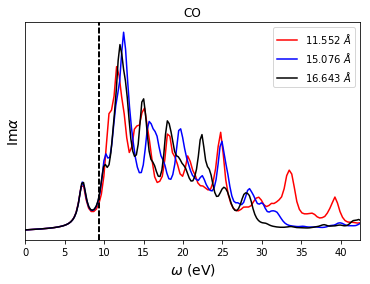

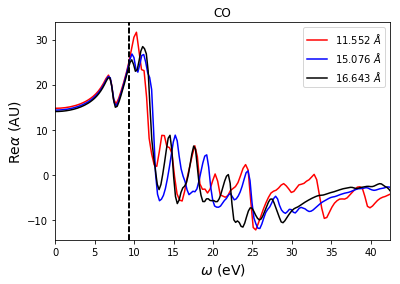

---------------- Excitation landscapes


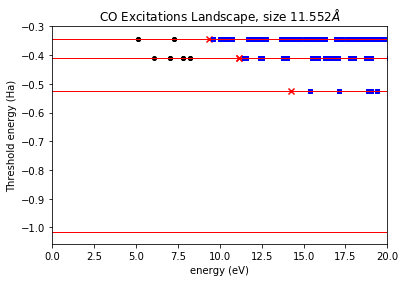

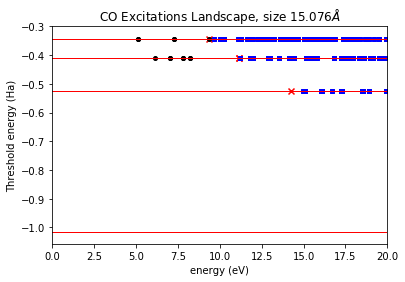

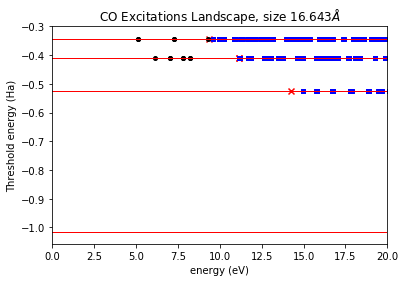

---------------- Dynamical polarizability, localized excitations only


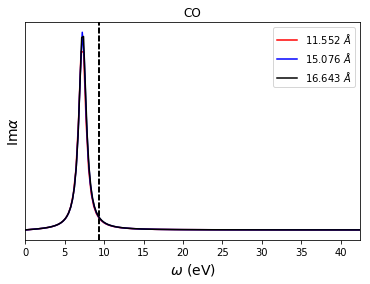

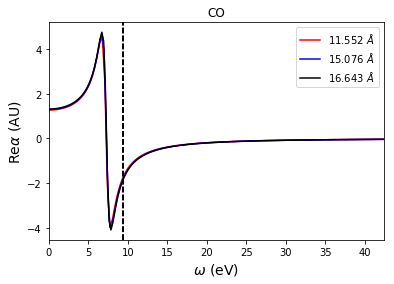

---------------- Excitations density of states, complete and splitted


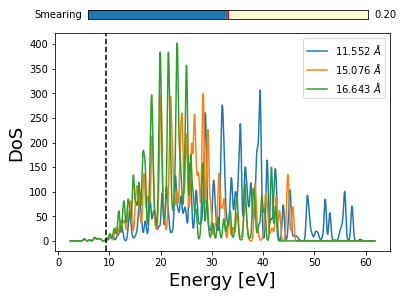

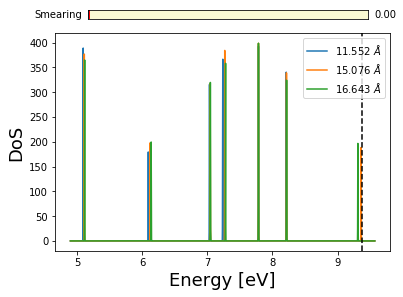

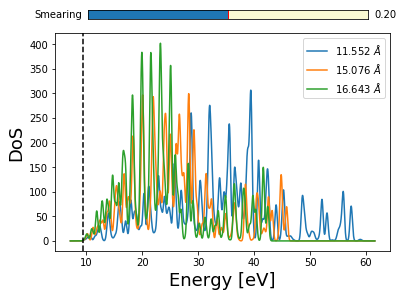

---------------- Static polarizability sum rule, "x" coordinate


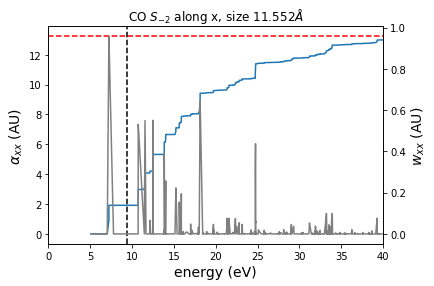

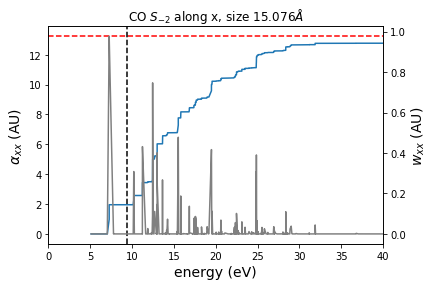

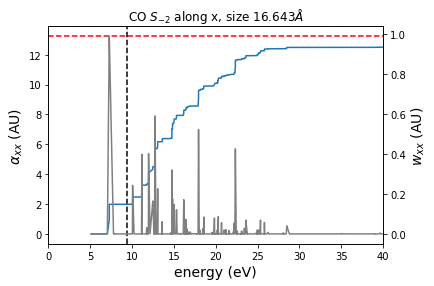

---------------- Static polarizability sum rule, "y" coordinate


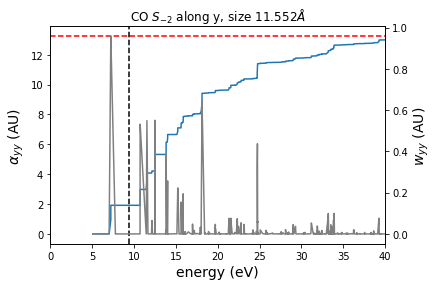

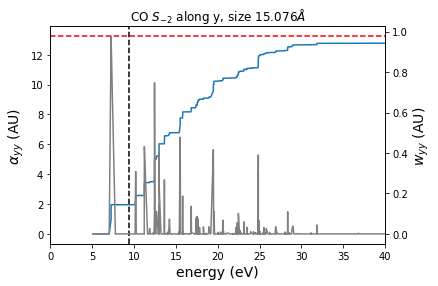

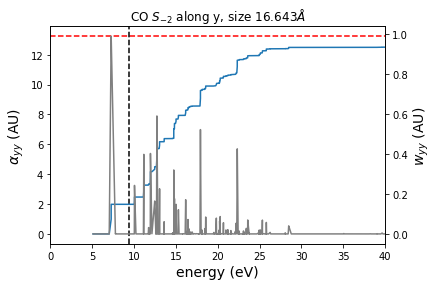

---------------- Static polarizability sum rule, "z" coordinate


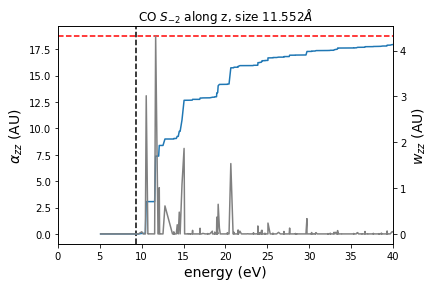

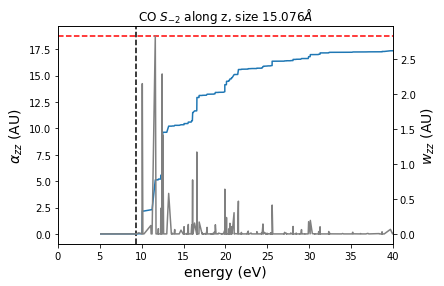

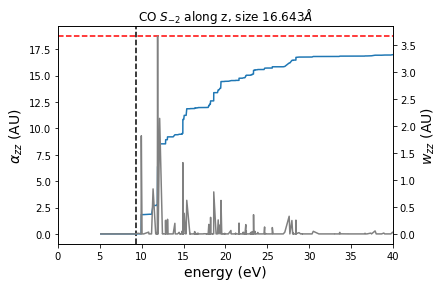

In [13]:
analyze_molecule_data('CO',CO_data,alpha_ref=CO_alpha_ref)

## Considerations
The CO molecule has only localized states below the first ionization threshold. For this reason its excitation spectrum is deeply influenced by the excitation density of states in the continuum sector. This is particularly visible in the sum-rule for the static polarizability, where it can be seen that only the states
above threshold contributes. However, there is a bright peak in the below-threshod regime that easily converges with respect to the size of the simulation domain.

# The Benzene molecule
We now perform the same analysis with a slightly larger molecule, Benzene.
We also here provide the reference static polarizability values for comparison.

In [14]:
C6H6_alpha_ref = [83.86,83.86,45.62]

In [15]:
C6H6_data=read_data_directory('C6H6/linear-response/log')

Loading data with  (15,)  occupied and  (220,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/C6H6/linear-response/log/data-Rmult_9.0/coupling_matrix.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
Loading data with  (15,)  occupied and  (220,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/C6H6/linear-response/log/data-Rmult_9.0/transition_quantities.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Loading data with  (15,)  occupied and  (220,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/C6H6/linear-response/log/data-Rmult_7.0/coupling_matrix.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
Loading data with  (15,)  occupied and  (220,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/C6H6/linear-response/log/data-Rmult_7.0/transition_quantities.txt "
Using pandas:
done
Shape is conformal with the number of o

In [16]:
calculate_excitations(C6H6_data)

Diagonalizing Coupling matrix of shape (6600, 6600)
Eigensystem solved
Diagonalizing Coupling matrix of shape (6600, 6600)
Eigensystem solved
Diagonalizing Coupling matrix of shape (6600, 6600)
Eigensystem solved


In [17]:
split_excitations(molecule_data=C6H6_data,tol=5.e-2)

Splitting excitations for run of size 15.664 , tolerance= 0.05
Found  41 / 6600  excitations below threshold
Splitting excitations for run of size 18.839 , tolerance= 0.05
Found  47 / 6600  excitations below threshold
Splitting excitations for run of size 20.32 , tolerance= 0.05
Found  55 / 6600  excitations below threshold


---------------- Dynamical polarizability, imaginary and real part


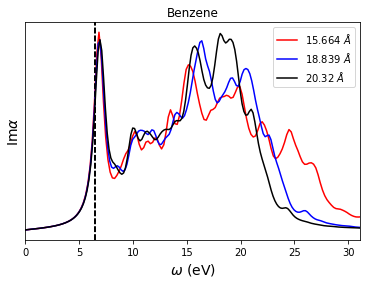

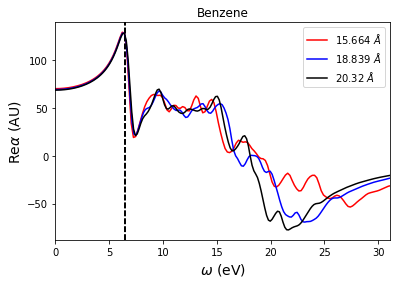

---------------- Excitation landscapes


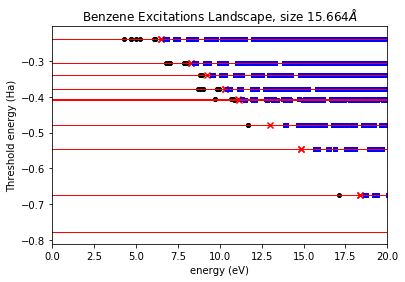

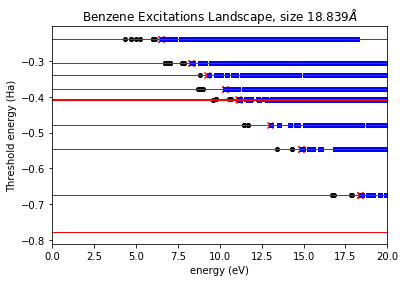

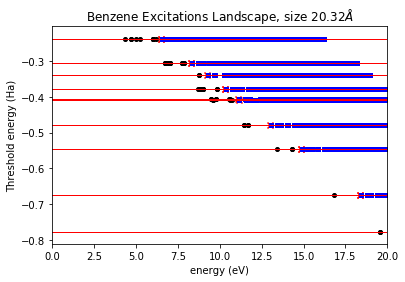

---------------- Dynamical polarizability, localized excitations only


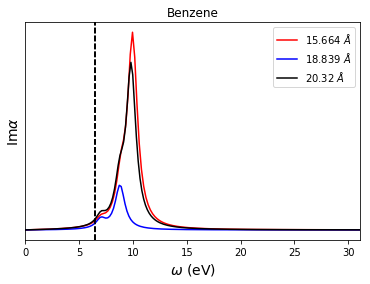

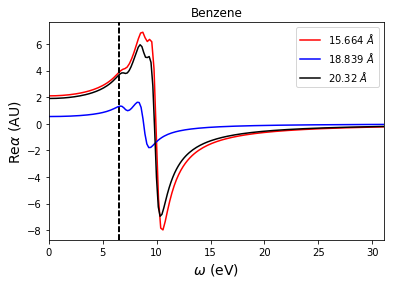

---------------- Excitations density of states, complete and splitted


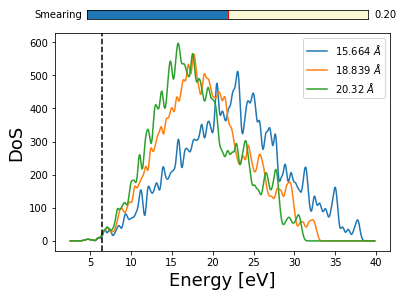

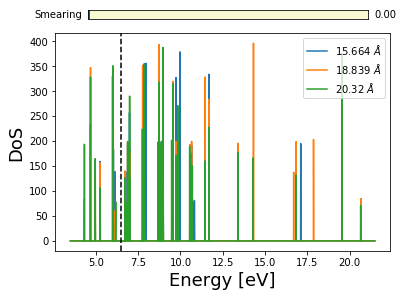

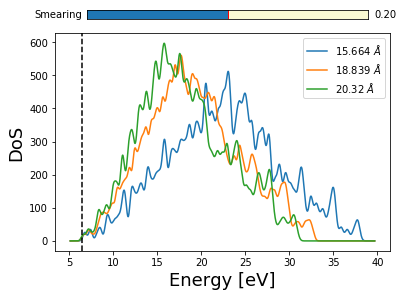

---------------- Static polarizability sum rule, "x" coordinate


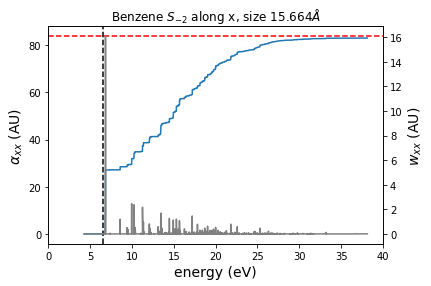

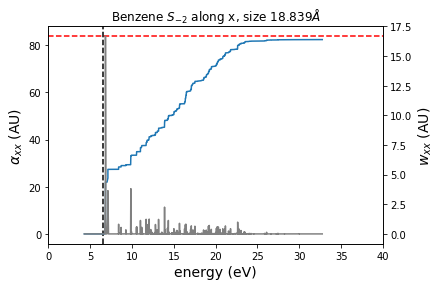

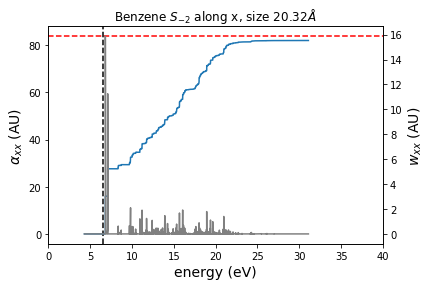

---------------- Static polarizability sum rule, "y" coordinate


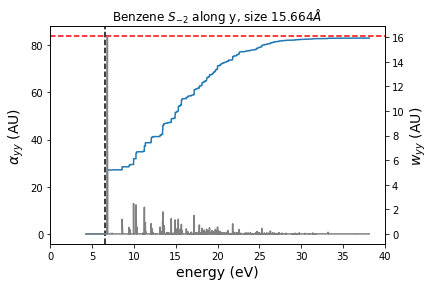

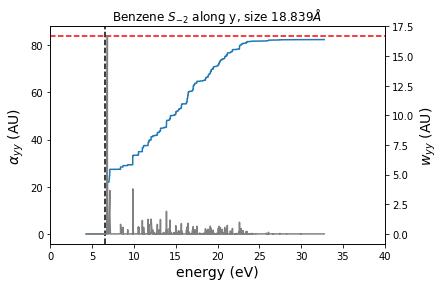

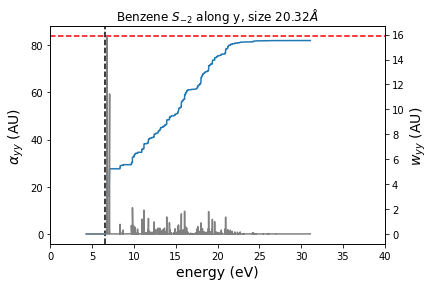

---------------- Static polarizability sum rule, "z" coordinate


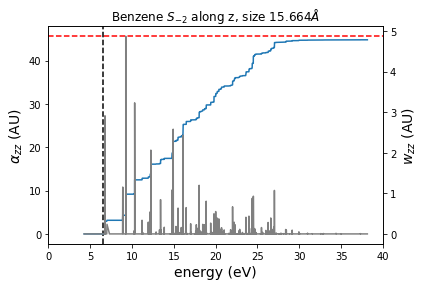

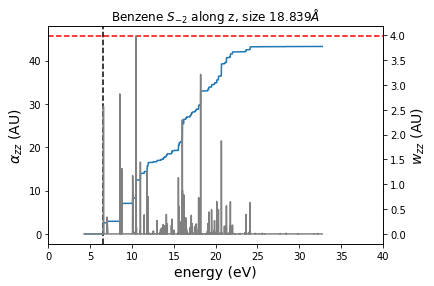

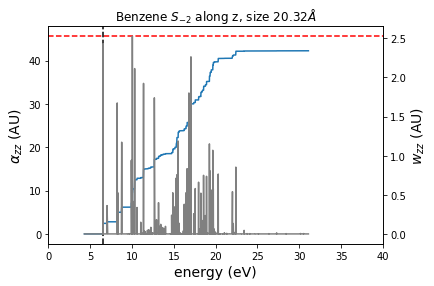

In [18]:
analyze_molecule_data('Benzene',C6H6_data,alpha_ref=C6H6_alpha_ref)

## Considerations
The Benzene molecule has also some localized excitations above the first ionization threshold, though their identification might be noisy.
In particular, the box of intermediate size might exhibit some extra degeneracies of the localized excitations with some delocalized states in the continuum, which hinders their identification with the naive method implemented here.
Nonetheless, it appears clearly that these localized portion of the spectra, are *not* sufficient to express the linear-response properties of the molecule.
This is visible either from the absorption spectra, which are drastically different by only considering below-threshold excitations, and also from the static polarizability sum rule, which incidentally is very-well satisfied also for the small box. As a further confirmation we plot here the $S_{-2}$ plot for the localized states only of the small box size:


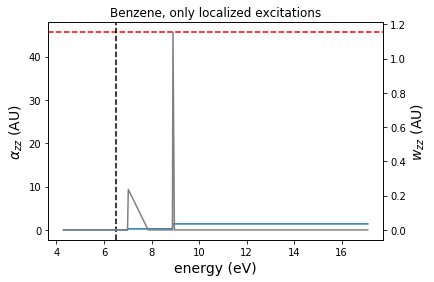

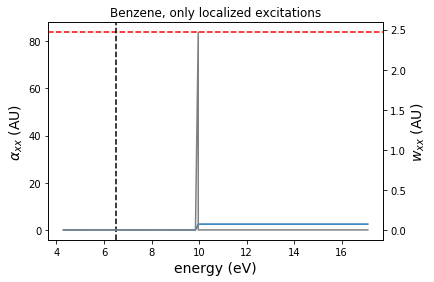

In [22]:
ex=C6H6_data[7.0]['excitations']
pt=ex.plot_Sminustwo(coord='z',group='bt',alpha_ref=C6H6_alpha_ref)
pt.title('Benzene, only localized excitations')
pt.show()
pt=ex.plot_Sminustwo(coord='x',group='bt',alpha_ref=C6H6_alpha_ref)
pt.title('Benzene, only localized excitations')
pt.show()

We can easily see that the localized sector is *strongly* insufficient to encode LR information on $\alpha(\omega=0)$, even if the corresponding fluctuation state is localized.

# Water molecule
We may also retrieve the same quantities for the $H_2O$ molecule. We provide approximate values for the $alpha_{yy}$ component in this preliminary example.

In [30]:
H2O_alpha_ref=[10.92749556,10.92749556,10.743]

In [27]:
H2O_data=read_data_directory('../H2O/linear-response/log')

Loading data with  (4,)  occupied and  (297,)  empty states, from file " /LR-nb/POLARIZABILITY/H2O/linear-response/log/data-Rmult_7.0/coupling_matrix.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
Loading data with  (4,)  occupied and  (297,)  empty states, from file " /LR-nb/POLARIZABILITY/H2O/linear-response/log/data-Rmult_7.0/transition_quantities.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Loading data with  (4,)  occupied and  (283,)  empty states, from file " /LR-nb/POLARIZABILITY/H2O/linear-response/log/data-Rmult_9.0/coupling_matrix.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
Loading data with  (4,)  occupied and  (283,)  empty states, from file " /LR-nb/POLARIZABILITY/H2O/linear-response/log/data-Rmult_9.0/transition_quantities.txt "
Using pandas:
done
Shape is conformal with the number of orbitals


In [28]:
calculate_excitations(H2O_data)

Diagonalizing Coupling matrix of shape (2376, 2376)
Eigensystem solved
Diagonalizing Coupling matrix of shape (2264, 2264)
Eigensystem solved


In [29]:
split_excitations(H2O_data)

Splitting excitations for run of size 12.335 , tolerance= 0.01
Found  2 / 2376  excitations below threshold
Splitting excitations for run of size 15.468 , tolerance= 0.01
Found  2 / 2264  excitations below threshold


**WARNING**: due to a (corrected!) error in the initial calculation the oscillator strenghts are multiplied by the square number of MPI processes.
We therefore compare the references wrt the multiplied values. **There is a multiplicative factor on the oscillator strenghts**

---------------- Dynamical polarizability, imaginary and real part


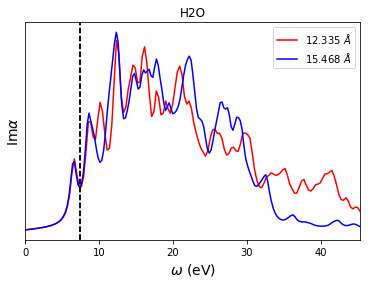

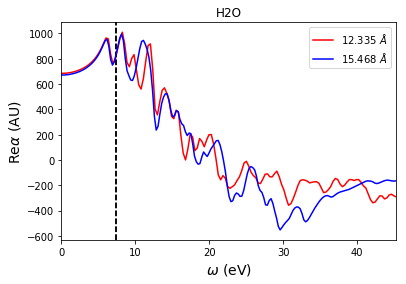

---------------- Excitation landscapes


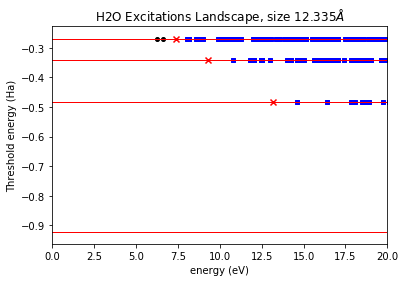

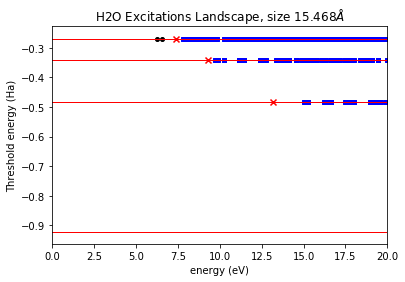

---------------- Dynamical polarizability, localized excitations only


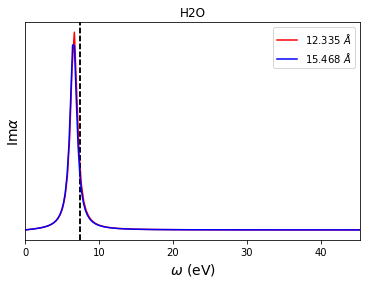

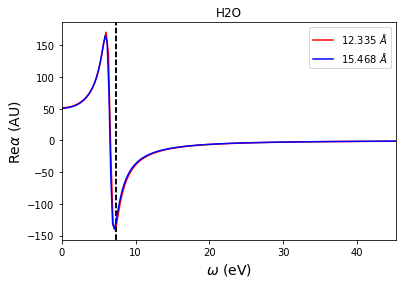

---------------- Excitations density of states, complete and splitted


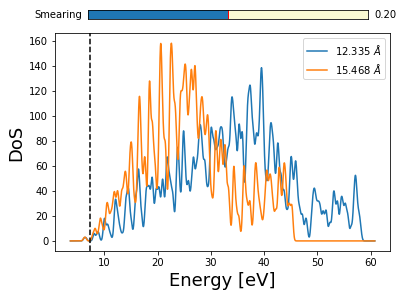

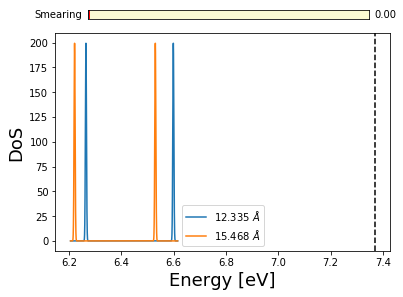

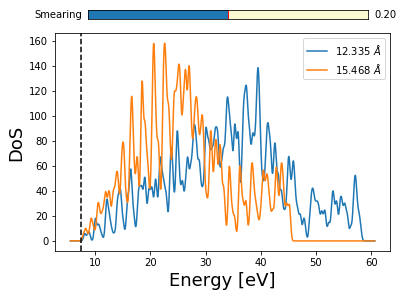

---------------- Static polarizability sum rule, "x" coordinate


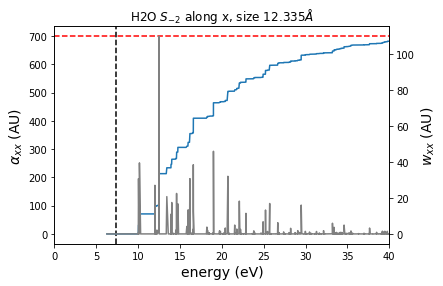

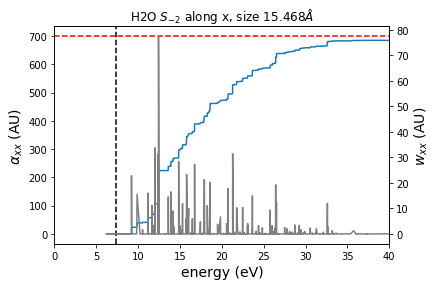

---------------- Static polarizability sum rule, "y" coordinate


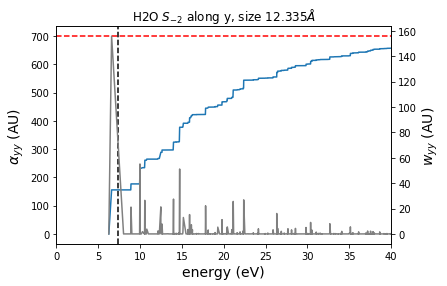

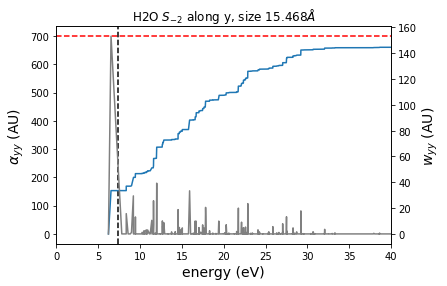

---------------- Static polarizability sum rule, "z" coordinate


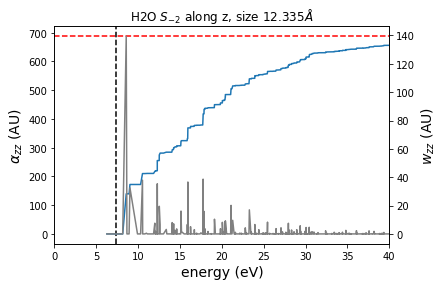

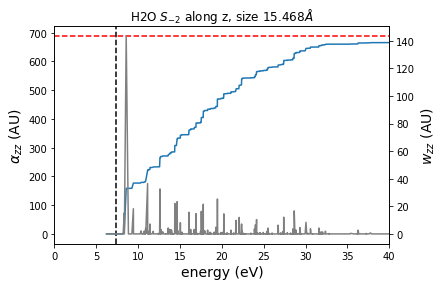

In [33]:
analyze_molecule_data('H2O',H2O_data,alpha_ref=64*np.array(H2O_alpha_ref))

## Considerations.
The Water molecule behaves very much like the CO case, with a bright peak below threshold. However it might be seen that the localized excitations are not yet at convergence with the largest box size, as their energy value are moved wrt the small box. However, the panorama is largely dominated by the continuum sector of the excitations.

# The Nitrogen molecule
We also look here at a molecule which has _no bright_ peaks below threshold, like the $N_2$.

In [34]:
N2_alpha_ref=[10.868,10.868,15.735]

In [35]:
N2_data=read_data_directory('../N2/free-bc/linear-response/log/')

Loading data with  (5,)  occupied and  (280,)  empty states, from file " /LR-nb/POLARIZABILITY/N2/free-bc/linear-response/log/data-Rmult_7.0/coupling_matrix.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
Loading data with  (5,)  occupied and  (280,)  empty states, from file " /LR-nb/POLARIZABILITY/N2/free-bc/linear-response/log/data-Rmult_7.0/transition_quantities.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Loading data with  (5,)  occupied and  (280,)  empty states, from file " /LR-nb/POLARIZABILITY/N2/free-bc/linear-response/log/data-Rmult_10.0/coupling_matrix.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
Loading data with  (5,)  occupied and  (280,)  empty states, from file " /LR-nb/POLARIZABILITY/N2/free-bc/linear-response/log/data-Rmult_10.0/transition_quantities.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Loadin

In [36]:
calculate_excitations(N2_data)

Diagonalizing Coupling matrix of shape (2800, 2800)
Eigensystem solved
Diagonalizing Coupling matrix of shape (2800, 2800)
Eigensystem solved
Diagonalizing Coupling matrix of shape (2800, 2800)
Eigensystem solved


In [37]:
split_excitations(N2_data)

Splitting excitations for run of size 11.219 , tolerance= 0.01
Found  13 / 2800  excitations below threshold
Splitting excitations for run of size 13.97 , tolerance= 0.01
Found  13 / 2800  excitations below threshold
Splitting excitations for run of size 15.452 , tolerance= 0.01
Found  13 / 2800  excitations below threshold


---------------- Dynamical polarizability, imaginary and real part


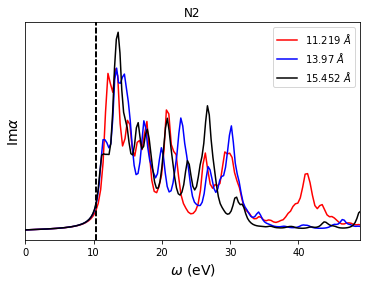

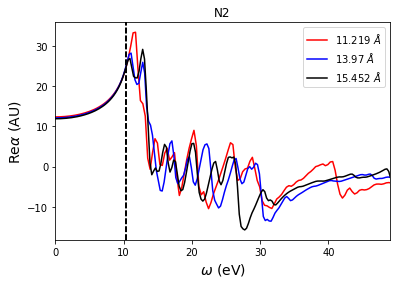

---------------- Excitation landscapes


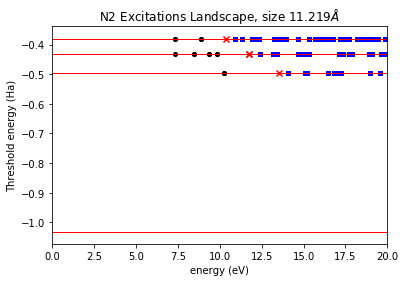

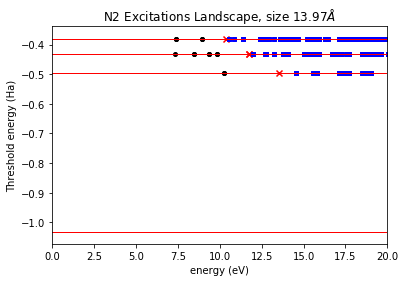

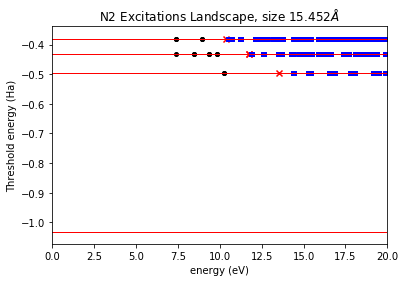

---------------- Dynamical polarizability, localized excitations only


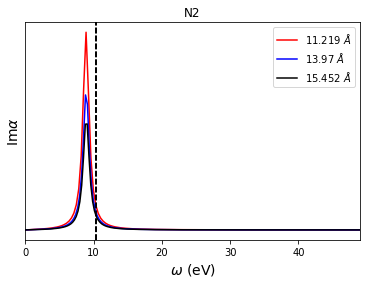

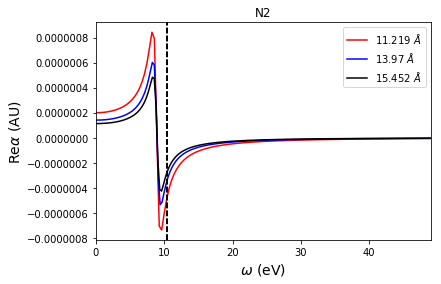

---------------- Excitations density of states, complete and splitted


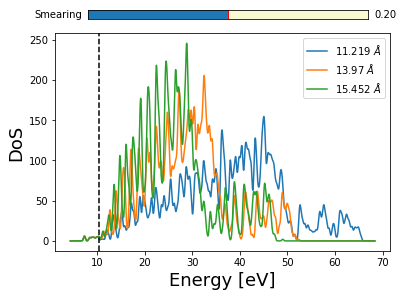

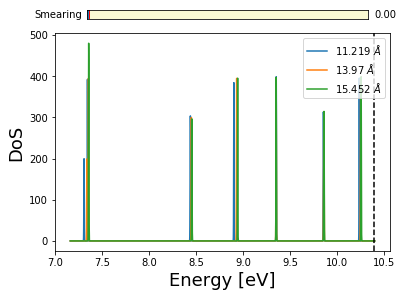

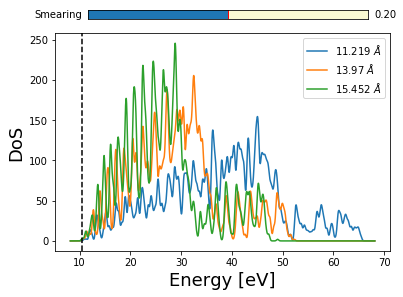

---------------- Static polarizability sum rule, "x" coordinate


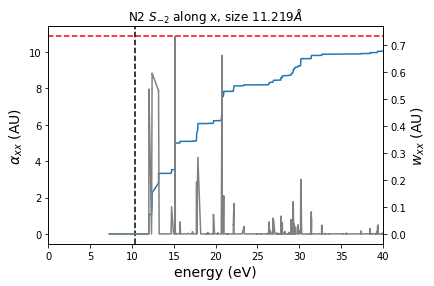

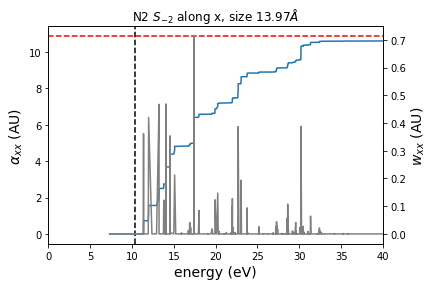

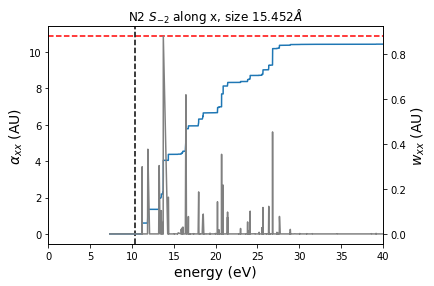

---------------- Static polarizability sum rule, "y" coordinate


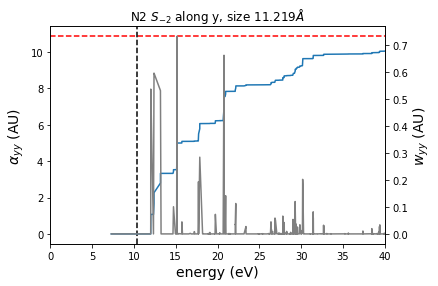

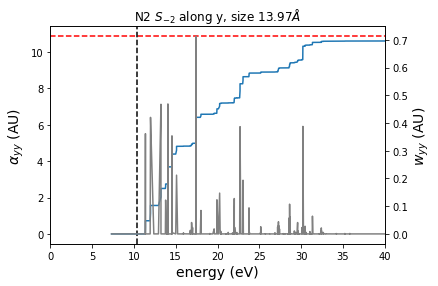

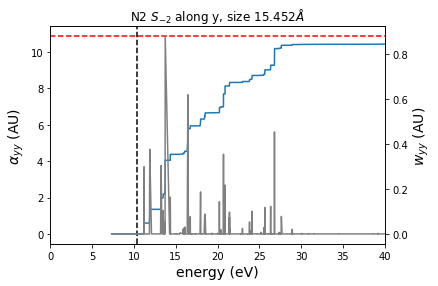

---------------- Static polarizability sum rule, "z" coordinate


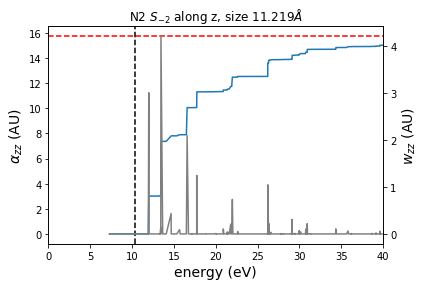

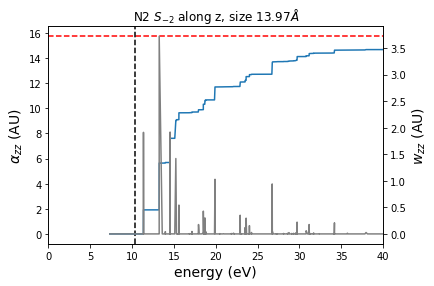

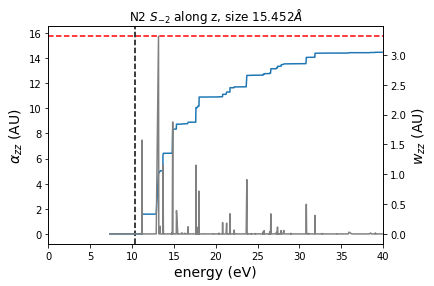

In [38]:
analyze_molecule_data('N2',N2_data,alpha_ref=N2_alpha_ref)

## Considerations, and further analysis
The absence of bright peaks below threshold complicates the task of finding a converged absorbption spectrum for the $N_2$ molecule.
However, there is a number of localized excitations below threshold that seem to be stable and converge wrt the simulation box size.
Rather surprisigly, the **first** excitation of nitrogen exhibit a behaviour which is box-dependent. its energy is:

In [45]:
write('Energy of the first state',[np.sqrt(N2_data[run]['excitations'].eigenvalues[0])*LR.HaeV for run in sorted_keys(N2_data)])
write('Energy of the second state',[np.sqrt(N2_data[run]['excitations'].eigenvalues[1])*LR.HaeV for run in sorted_keys(N2_data)])
write('Energy of the third state',[np.sqrt(N2_data[run]['excitations'].eigenvalues[2])*LR.HaeV for run in sorted_keys(N2_data)])
write('Energy of the fourth state',[np.sqrt(N2_data[run]['excitations'].eigenvalues[3])*LR.HaeV for run in sorted_keys(N2_data)])
write('Energy of the fifth state',[np.sqrt(N2_data[run]['excitations'].eigenvalues[4])*LR.HaeV for run in sorted_keys(N2_data)])
write('Energy of the sixth state',[np.sqrt(N2_data[run]['excitations'].eigenvalues[5])*LR.HaeV for run in sorted_keys(N2_data)])

Energy of the first state [7.308273144120822, 7.338207052819042, 7.35537202686916]
Energy of the second state [7.344004273115779, 7.354575430610572, 7.358312219023874]
Energy of the third state [7.3443987189945865, 7.354579978000688, 7.358315168774006]
Energy of the fourth state [8.436739626027292, 8.447456650650208, 8.451661510472356]
Energy of the fifth state [8.439698496651037, 8.45044387312135, 8.454637012163287]
Energy of the sixth state [8.900361888025166, 8.929774507146037, 8.940145592620116]


In [48]:
write('Thresholds levels (Ha), first state',[N2_data[run]['excitations'].threshold_energies[0]*LR.HaeV for run in sorted_keys(N2_data)])
write('Thresholds levels (Ha), second state',[N2_data[run]['excitations'].threshold_energies[1]*LR.HaeV for run in sorted_keys(N2_data)])
write('Thresholds levels (Ha), third state',[N2_data[run]['excitations'].threshold_energies[2]*LR.HaeV for run in sorted_keys(N2_data)])

Thresholds levels (Ha), first state [-11.741005991078694, -11.741240401468211, -11.741242138937574]
Thresholds levels (Ha), second state [-10.394640815885154, -10.394886811682248, -10.394895711413888]
Thresholds levels (Ha), third state [-10.394640815885154, -10.394886811682248, -10.394895711413888]


At the LDA level of theory, the HOMO and the HOMO-1 have different levels of degeneracy:

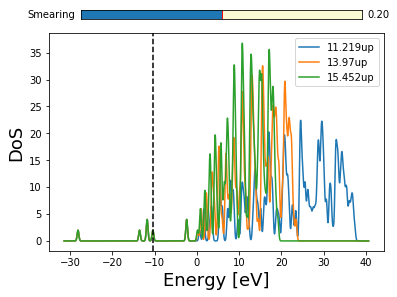

In [59]:
runs=sorted_keys(N2_data)
run=runs[0]
mol=N2_data[run]
dos=mol['log'].get_dos(label=str(mol['size']))
for run in runs[1:]:
    mol=N2_data[run]
    dos.append_from_bandarray(mol['log'].evals,label=str(mol['size']))
dos.plot()

In this figure we see both the degeneracy of the HOMO-1 and the continuum collapse of the KS states.

# Fullerene molecule
We have also available a calculation (made with a previous version of the code using different conventions for the transition quantities)
For the $C_{60}$ molecule. Let us grab this data.

In [70]:
C60_alpha_ref=[561.594233465,561.594233465,561.594233465]

In [68]:
C60_data=read_data_directory('../C60/linear-response/log/')

Loading data with  (120,)  occupied and  (112,)  empty states, from file " /LR-nb/POLARIZABILITY/C60/linear-response/log/data-Rmult_7.0/coupling_matrix.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
The transition multipoles were not loaded, try with old code format
Loading data with  (120,)  occupied and  (112,)  empty states, from file " /LR-nb/POLARIZABILITY/C60/linear-response/log/data-Rmult_7.0/transition_dipoles.txt "
Using pandas:
done
Shape is conformal with the number of orbitals


As anticipated the reading of the Transition Quantities did not went through. Let us analyse the `TransitionDipoles` class instead.

In [69]:
calculate_excitations(C60_data)

Diagonalizing Coupling matrix of shape (26880, 26880)
Eigensystem solved


Let us split the excitations.

In [109]:
split_excitations(C60_data)

Splitting excitations for run of size 18.627 , tolerance= 0.01
Found  3345 / 26880  excitations below threshold


---------------- Dynamical polarizability, imaginary and real part


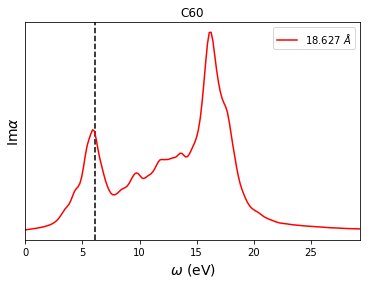

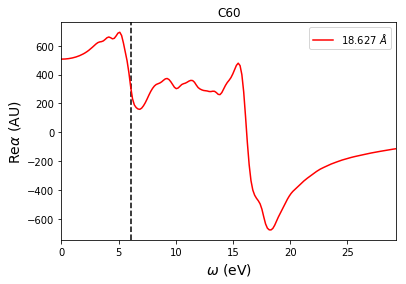

---------------- Excitation landscapes


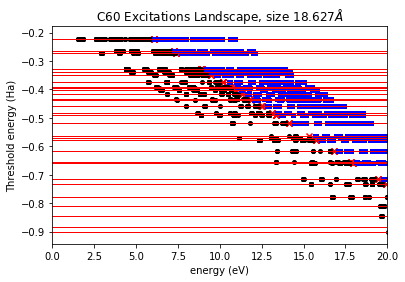

---------------- Dynamical polarizability, localized excitations only


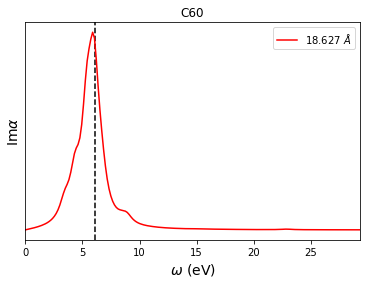

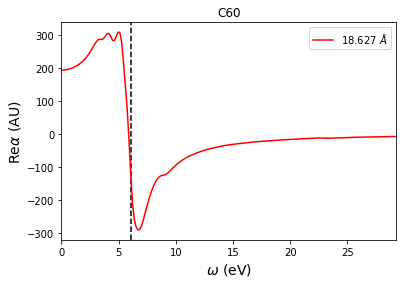

---------------- Excitations density of states, complete and splitted


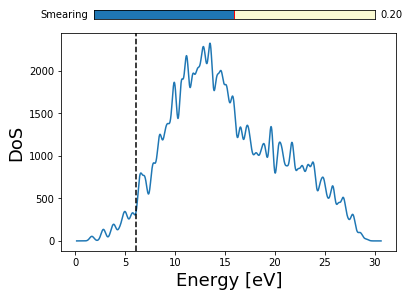

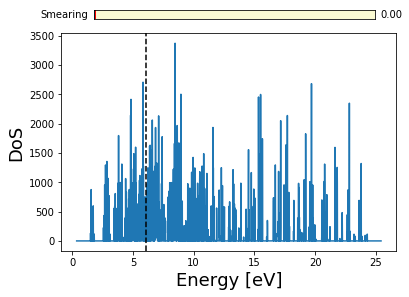

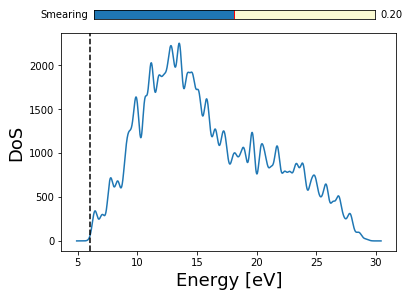

---------------- Static polarizability sum rule, "x" coordinate


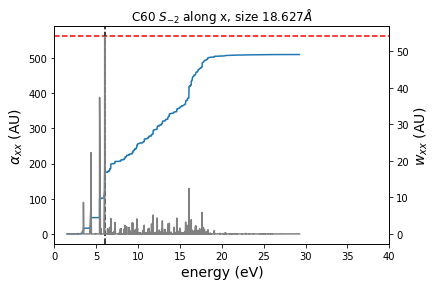

---------------- Static polarizability sum rule, "y" coordinate


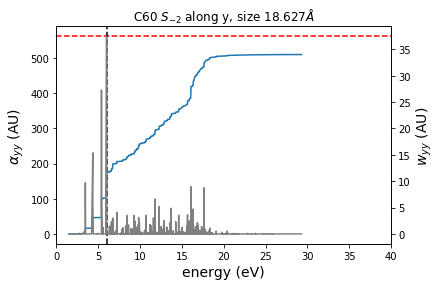

---------------- Static polarizability sum rule, "z" coordinate


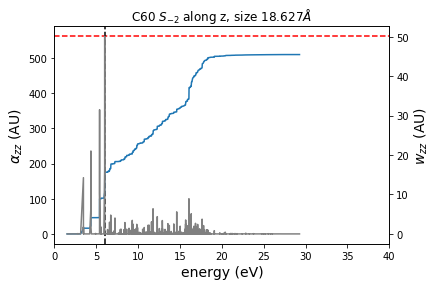

In [110]:
analyze_molecule_data('C60',C60_data,alpha_ref=C60_alpha_ref)

## Considerations
The Fullerene molecule, as it is larger, presents a large number  of localized excitation in the spectrum.
In addition this is in line with the consideration that localized states might contribute more to the static polarizability.
Let us verify this explicitly:

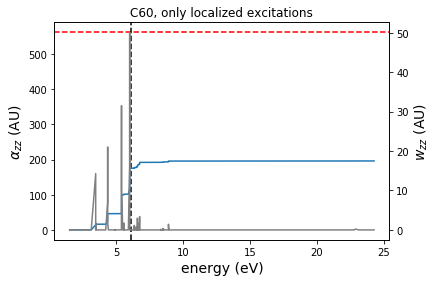

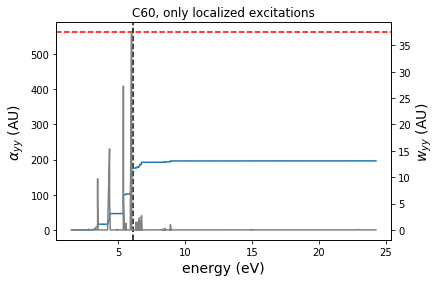

In [111]:
ex=C60_data[7.0]['excitations']
pt=ex.plot_Sminustwo(coord='z',group='bt',alpha_ref=C60_alpha_ref)
pt.title('C60, only localized excitations')
pt.show()
pt=ex.plot_Sminustwo(coord='y',group='bt',alpha_ref=C60_alpha_ref)
pt.title('C60, only localized excitations')
pt.show()

It might be also interesting to verify which portion of the absorbtion spectra are captured by the localized states in this case.

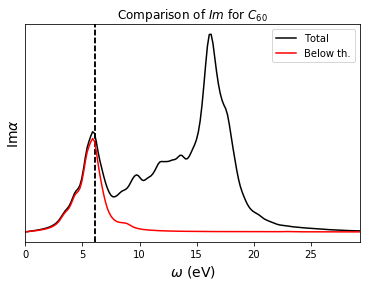

In [112]:
pt=ex.plot_alpha(c='black',label='Total')
pt=ex.plot_alpha(group='bt',c='red',label='Below th.')
pt.legend(loc='best')
pt.title('Comparison of $Im \alpha(\omega)$ for $C_{60}$')
pt.show()


# Aflatoxins
We now have a look at a molecule with no particular symmetry, the Aflaxotin, in its B1 and G2 variants.
These two molecules have different number of atoms. We however include them in the same dataset as they exhibit similar LR properties.
We do not have the reference value for the static polarizability at present.

In [104]:
afla_data=read_data_directory('../Aflatoxin/')

Loading data with  (58,)  occupied and  (128,)  empty states, from file " /LR-nb/POLARIZABILITY/Aflatoxin/data-GS-b1/coupling_matrix.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
Loading data with  (58,)  occupied and  (128,)  empty states, from file " /LR-nb/POLARIZABILITY/Aflatoxin/data-GS-b1/transition_quantities.txt "
Using pandas:
done
Shape is conformal with the number of orbitals


In [105]:
calculate_excitations(afla_data)

Diagonalizing Coupling matrix of shape (14848, 14848)
Eigensystem solved


In [106]:
split_excitations(afla_data)

Splitting excitations for run of size 17.426 , tolerance= 0.01
Found  112 / 14848  excitations below threshold


---------------- Dynamical polarizability, imaginary and real part


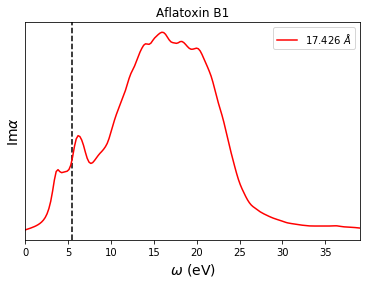

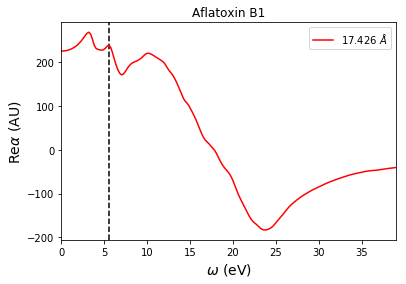

---------------- Excitation landscapes


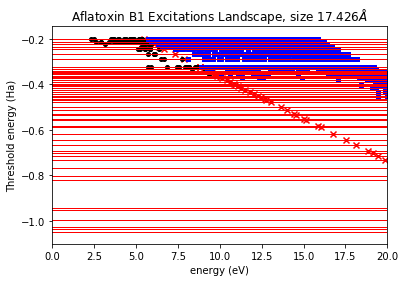

---------------- Dynamical polarizability, localized excitations only


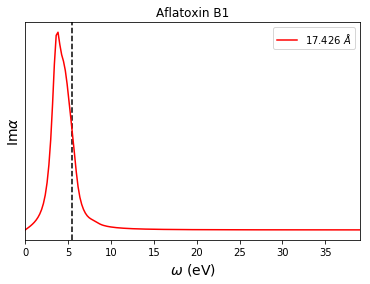

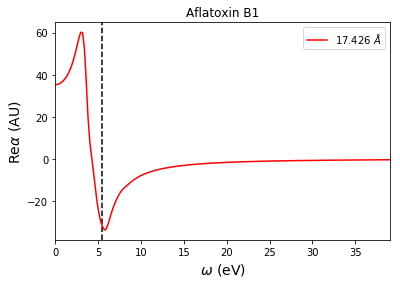

---------------- Excitations density of states, complete and splitted


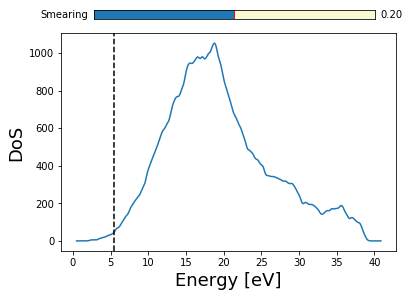

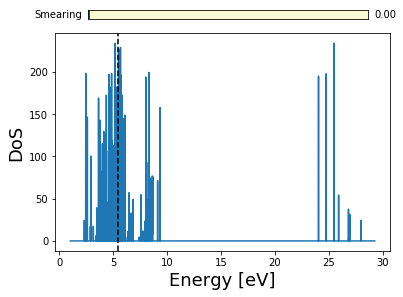

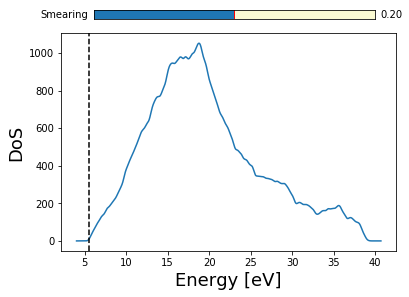

---------------- Static polarizability sum rule, "x" coordinate


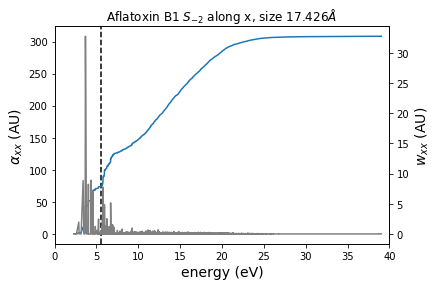

---------------- Static polarizability sum rule, "y" coordinate


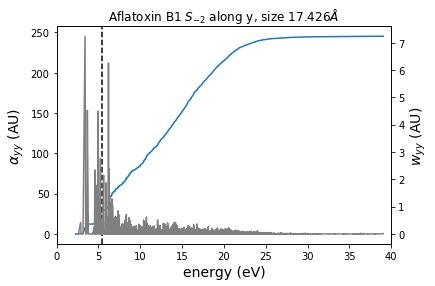

---------------- Static polarizability sum rule, "z" coordinate


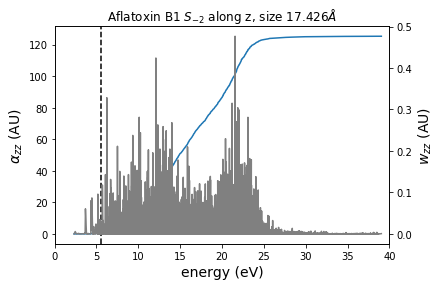

In [107]:
analyze_molecule_data('Aflatoxin B1',afla_data)

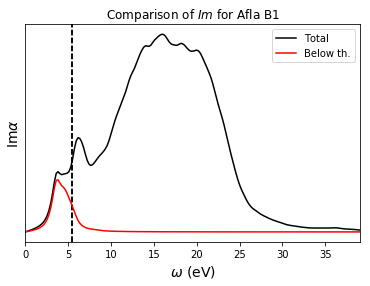

In [108]:
ex=afla_data[5.0]['excitations']
pt=ex.plot_alpha(c='black',label='Total')
pt=ex.plot_alpha(group='bt',c='red',label='Below th.')
pt.legend(loc='best')
pt.title('Comparison of $Im \alpha(\omega)$ for Afla B1')
pt.show()


# LR Analysis

In [ ]:
def build_syst_dict(systPath,norb):
    syst = {}
    outp = systPath+'/log'
    %cd $outp
    logs = !ls log-Rmult_*
    for l in logs:
        data = lf.Logfile(l)
        rmult = data.log['dft']['rmult'][0]
        nvirt = len(data.evals[0][0]) - norb
        syst[rmult] = {'nvirt':nvirt}
    %cd ../../../
    return syst
    
def get_tddft_quantities(syst,sysPath):
    from futile.Utils import write
    outp = sysPath+'/log'
    %cd $outp
    for rVal in syst:
        dpath = 'data-'+'Rmult_'+str(rVal)+'/transition_quantities.txt'
        trans = np.loadtxt(dpath)
        syst[rVal]['T']=trans
        cpath = 'data-'+'Rmult_'+str(rVal)+'/coupling_matrix.txt'
        Cmat = np.loadtxt(cpath)
        syst[rVal]['C']=Cmat
        write('Casida Matrix is symmetric',np.allclose(Cmat,Cmat.T,atol=1.e-12))
        syst[rVal]['logfile'] = lf.Logfile('log-Rmult_'+str(rVal)+'_numVirt_'+str(syst[rVal]['nvirt'])+'.yaml')
    %cd ../../../

This notebook analyze the LR properties of a system. It assumes that the TDDFT-BigDFT computation has already been performed.

## Analysis of the $CO$ molecule

In [3]:
norbCO = 5
pathCO = 'CO/linear-response/'
CO = build_syst_dict(pathCO, norbCO)
CO

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper/CO/linear-response/log
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper


{7.0: {'nvirt': 280}, 9.0: {'nvirt': 280}, 10.0: {'nvirt': 280}}

In [4]:
get_tddft_quantities(CO,pathCO)

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper/CO/linear-response/log
Casida Matrix is symmetric True
Casida Matrix is symmetric True
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper


Solve the Casida eigenproblems using naSmall virtual orbitals. In this example the choice naSmall = nvirt is performed but the actual number of virtual orbitals can be reduced to check the convergence of the results w.r.t. the 
dimension of the basis in the empty-state subspace.

In [6]:
naSmall = [280]

In [7]:
reload(LR)
LR.diagonalize_CM(norbCO,CO,naSmall)
LR.collect_LR(CO)

Solve for rVal =  9.0
Eigensystem solved for 280
Solve for rVal =  10.0
Eigensystem solved for 280
Solve for rVal =  7.0
Eigensystem solved for 280


#### Dynamical polarizability

In [8]:
reload(LR)
CO_spectrum = LR.collect_spectrum(CO)

Compute for rVal =  9.0  with nalpha =  280
numpoint =  336  omegaMax (eV) =  45.8183849825
Compute for rVal =  10.0  with nalpha =  280
numpoint =  311  omegaMax (eV) =  42.431982253
Compute for rVal =  7.0  with nalpha =  280
numpoint =  434  omegaMax (eV) =  59.1066901023


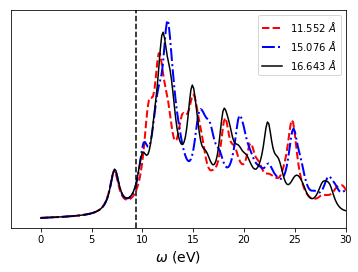

In [9]:
%matplotlib inline
syst = CO_spectrum
part = 'imagPart' #use 'realPart' to plot the real part of the dynamical polarizability
size = str(CO[7.0]['logfile'].log['Sizes of the simulation domain']['Angstroem'][2])
plt.plot(syst[7.0]['omega'],syst[7.0][part],'--',c='red',linewidth=2,label= size + ' $\AA$')
size = str(CO[9.0]['logfile'].log['Sizes of the simulation domain']['Angstroem'][2])
plt.plot(syst[9.0]['omega'],syst[9.0][part],'-.',c='blue',linewidth=2,label= size + ' $\AA$')
size = str(CO[10.0]['logfile'].log['Sizes of the simulation domain']['Angstroem'][2])
plt.plot(syst[10.0]['omega'],syst[10.0][part],'-',c='black',linewidth=1.5,label= size + ' $\AA$')
plt.xlim(xmax=30)
plt.yticks([])
plt.xlabel(r'$\omega$ (eV)',size = 14)
#plt.title('Absorption spectrum')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[7.0]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.legend(loc='best')
plt.show()

### Excitation Landscape

We attribute to the first numExc excitations a threshold key ('th') that contain the value of the psi_p of highest energy that contributes to the excitation, with a threshold level given by th_value. We take into account the degenaracy of the psi_p states to build the threshold levels.  

In [63]:
th_value = 1e-4
th_levels = [1,2,3,3,4]

In [64]:
numExcCO = 2800
LR.collect_excitation_thr(CO,norbCO,numExcCO,th_levels,th_value)
CO_channels = LR.collect_channels(CO,norbCO,numExcCO,th_levels)

We plot the excitation landscape

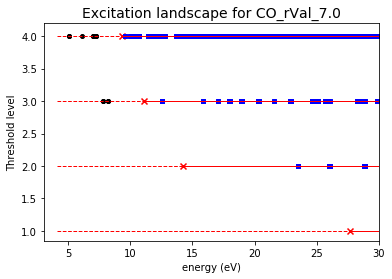

In [65]:
r = 7.0 # choice of the box size

nalpha = CO[r]['eigenproblems'].keys()
nalpha.sort()
nvirt = nalpha[-1]
syst = CO[r]['eigenproblems'][nvirt]
th_energies = HaeV*abs(LR.get_p_energy(CO[r]['logfile'],norbCO))

Emin = HaeV*np.sqrt(syst['eigenvalues'][0])-1
Emax = 30

for level in CO_channels[r]:
    eng_th = th_energies[th_levels.index(level)]
    plt.plot((Emin,eng_th),(level,level),'--',c='red',linewidth=1)
    plt.plot((eng_th,Emax),(level,level),'-',c='red',linewidth=1)
    plt.scatter(eng_th,level,marker='x',c='red')
  
    for exc in CO_channels[r][level]:
        if exc[1] < eng_th: 
            plt.scatter(exc[1],level,s=16,marker='o',c='black')
        else:
            plt.scatter(exc[1],level,s=14,marker='s',c='blue')
                
plt.title('Excitation landscape for CO_rVal_'+str(r),size=14) 
plt.xlabel('energy (eV)')
plt.ylabel('Threshold level')
plt.xlim(xmin=Emin-1,xmax=Emax)
plt.show()

### Excitation DOS

We identify the excitations below and above threshold

In [66]:
reload(LR)
CO_ind_bt,CO_ind_at = LR.collect_index_bt_at(CO)

Plot the Dos below threshold

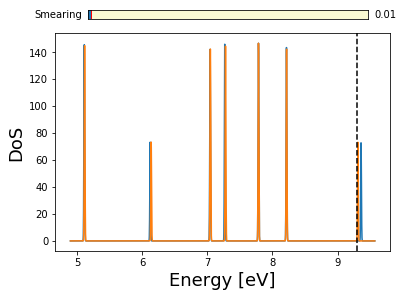

In [67]:
%matplotlib inline
dos=D.DoS(fermi_level=9.3)
for rVal in [9.0,10.0]: #CO:
    nalpha = CO[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(CO[rVal]['eigenproblems'][nvirt]['eigenvalues'][CO_ind_bt[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
dos.plot(sigma=0.0002*HaeV)

Plot the complete Dos

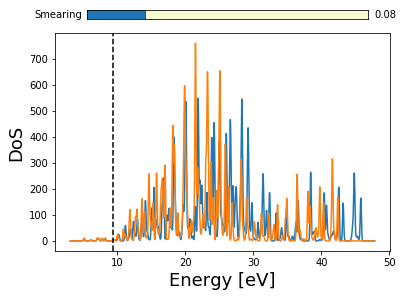

In [68]:
%matplotlib inline
dos=D.DoS(fermi_level=9.3)
for rVal in [9.0,10.0]: #CO:
    nalpha = CO[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(CO[rVal]['eigenproblems'][nvirt]['eigenvalues'][CO_ind_bt[rVal]+CO_ind_at[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
dos.plot(sigma=0.003*HaeV)

### Statical polarizability vs. number of excitations

We plot the converge plot of the statical polarizability to its reference (finite difference) value in function
of the number of excitations.

In [106]:
CO_alpha_ref = {'alphaX':13.235,'alphaY':13.235,'alphaZ':18.728}

In [107]:
r = 7.0 # box size
nvirt = CO[r]['nvirt']
e2 = CO[r]['eigenproblems'][nvirt]['eigenvalues']
e = HaeV*np.sqrt(e2)
f = HaeV**2*np.array(CO[r]['eigenproblems'][nvirt]['oscillator_strengths'])

w_zz = []
for exc in range(numExcCO):
    w_zz.append(2.0*f[exc][2])
    
alpha_zz = [0.0 for i in range(numExcCO)]
for ind,val in enumerate(w_zz):
    if ind>0:
        alpha_zz[ind] = alpha_zz[ind-1] + val/(e[ind]**2)

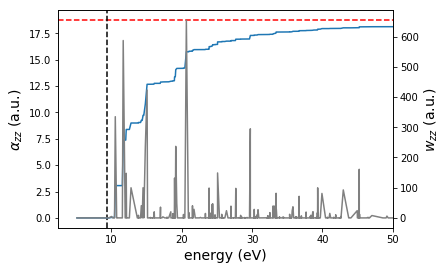

In [111]:
%matplotlib inline

fig, ax1 = plt.subplots()

ax1.set_xlabel('energy (eV)',size = 14)
plt.ylabel(r'$\alpha_{zz}$ (a.u.)',size = 14)
plt.axhline(y=CO_alpha_ref['alphaZ'], color='r', linestyle='--')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[rVal]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
ax1.plot(e,np.array(alpha_zz))

ax2 = ax1.twinx()
ax2.plot(e,w_zz,color='grey',linestyle='-')
plt.xlim(xmax=50)
plt.ylabel(r'$w_{zz}$ (a.u.)',size=14)
plt.show()

## Analysis of the Benzene molecule

In [36]:
norbC6H6 = 15
pathC6H6 = 'C6H6/linear-response/'
C6H6 = build_syst_dict(pathC6H6, norbC6H6)
C6H6

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper/C6H6/linear-response/log
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper


{7.0: {'nvirt': 220}, 9.0: {'nvirt': 220}, 10.0: {'nvirt': 220}}

In [37]:
reload(LR)
get_tddft_quantities(C6H6,pathC6H6)

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper/C6H6/linear-response/log
Casida Matrix is symmetric True
Casida Matrix is symmetric True
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper


Solve the Casida eigenproblems using naSmall virtual orbitals. In this example the choice naSmall = nvirt is performed but the actual number of virtual orbitals can be reduced to check the convergence of the results w.r.t. the 
dimension of the basis in the empty-state subspace.

In [39]:
naSmall = [220]

In [40]:
LR.diagonalize_CM(norbC6H6,C6H6,naSmall)
LR.collect_LR(C6H6)

Solve for rVal =  9.0
Eigensystem solved for 220
Solve for rVal =  10.0
Eigensystem solved for 220
Solve for rVal =  7.0
Eigensystem solved for 220


#### Dynamical polarizability

In [41]:
reload(LR)
C6H6_spectrum = LR.collect_spectrum(C6H6)

Compute for rVal =  9.0  with nalpha =  220
numpoint =  240  omegaMax (eV) =  32.740054836
Compute for rVal =  10.0  with nalpha =  220
numpoint =  228  omegaMax (eV) =  31.0830728297
Compute for rVal =  7.0  with nalpha =  220
numpoint =  280  omegaMax (eV) =  38.1274605755


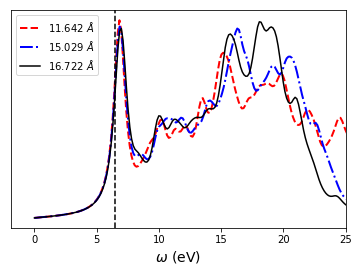

In [44]:
%matplotlib inline
syst = C6H6_spectrum
part = 'imagPart' #use 'realPart' to plot the real part of the dynamical polarizability
size = str(C6H6[7.0]['logfile'].log['Sizes of the simulation domain']['Angstroem'][2])
plt.plot(syst[7.0]['omega'],syst[7.0][part],'--',c='red',linewidth=2,label= size + ' $\AA$')
size = str(C6H6[9.0]['logfile'].log['Sizes of the simulation domain']['Angstroem'][2])
plt.plot(syst[9.0]['omega'],syst[9.0][part],'-.',c='blue',linewidth=2,label= size + ' $\AA$')
size = str(C6H6[10.0]['logfile'].log['Sizes of the simulation domain']['Angstroem'][2])
plt.plot(syst[10.0]['omega'],syst[10.0][part],'-',c='black',linewidth=1.5,label= size + ' $\AA$')
plt.xlim(xmax=25)
plt.yticks([])
plt.xlabel(r'$\omega$ (eV)',size = 14)
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[7.0]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.legend(loc='best')
plt.show()

### Excitation Landscape

We attribute to the first numExc excitations a threshold key ('th') that contain the value of the psi_p of highest energy that contributes to the excitation, with a threshold level given by th_value. We take into account the degenaracy of the psi_p states to build the threshold levels.  

In [112]:
th_value = 5e-2
th_levels = [1,2,2,3,3,4,5,5,6,6,7,8,8,9,9]

In [114]:
reload(LR)
numExcC6H6 = 220*15*2
LR.collect_excitation_thr(C6H6,norbC6H6,numExcC6H6,th_levels,th_value)
C6H6_channels = LR.collect_channels(C6H6,norbC6H6,numExcC6H6,th_levels)

We plot the excitations landscape

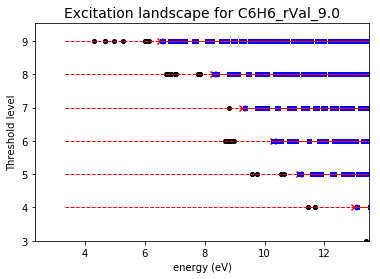

In [115]:
r = 9.0 # choice of the box size

nvirt = C6H6[r]['nvirt']
syst = C6H6[r]['eigenproblems'][nvirt]
th_energies = HaeV*abs(LR.get_p_energy(C6H6[r]['logfile'],norbC6H6))

Emin = HaeV*np.sqrt(syst['eigenvalues'][0])-1
Emax = 13.5

for level in C6H6_channels[r]:
    eng_th = th_energies[th_levels.index(level)]
    plt.plot((Emin,eng_th),(level,level),'--',c='red',linewidth=1)
    plt.plot((eng_th,Emax),(level,level),'-',c='red',linewidth=1)
    plt.scatter(eng_th,level,marker='x',c='red')
  
    for exc in C6H6_channels[r][level]:
        if exc[1] < eng_th: 
            plt.scatter(exc[1],level,s=16,marker='o',c='black')
        else:
            plt.scatter(exc[1],level,s=14,marker='s',c='blue')
                
plt.title('Excitation landscape for C6H6_rVal_'+str(r),size=14) 
plt.xlabel('energy (eV)')
plt.ylabel('Threshold level')
plt.xlim(xmin=Emin-1,xmax=Emax)
plt.ylim(ymin=3)
plt.show()

### Excitation DOS

We identify the excitations below and above threshold

In [116]:
reload(LR)
C6H6_ind_bt,C6H6_ind_at = LR.collect_index_bt_at(C6H6)

Plot the Dos below threshold

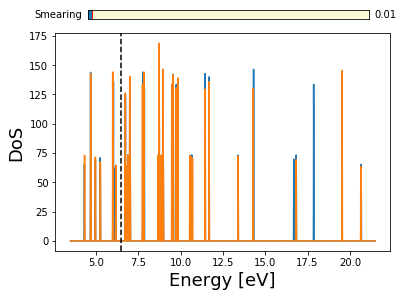

In [117]:
%matplotlib inline
dos=D.DoS(fermi_level=6.5)
for rVal in [9.0,10.0]:
    nalpha = C6H6[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(C6H6[rVal]['eigenproblems'][nvirt]['eigenvalues'][C6H6_ind_bt[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
dos.plot(sigma=0.0002*HaeV)

Plot the complete dos

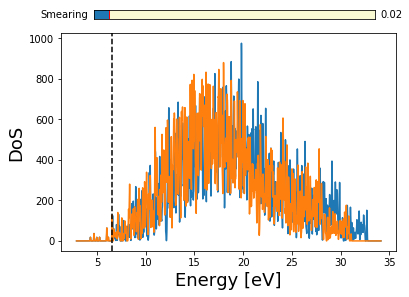

In [118]:
%matplotlib inline
dos=D.DoS(fermi_level=6.5)
for rVal in [9.0,10.0]:
    nalpha = C6H6[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(C6H6[rVal]['eigenproblems'][nvirt]['eigenvalues'][C6H6_ind_bt[rVal]+C6H6_ind_at[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
dos.plot(sigma=0.0008*HaeV)

### Statical polarizability vs. number of excitations

We plot the converge plot of the statical polarizability to its reference (finite difference) value in function
of the number of excitations.

In [119]:
C6H6_alpha_ref = {'alphaX':83.86,'alphaY':83.86,'alphaZ':45.62}

In [128]:
r = 7.0 # box size
nvirt = C6H6[r]['nvirt']
e2 = C6H6[r]['eigenproblems'][nvirt]['eigenvalues']
e = HaeV*np.sqrt(e2)
f = HaeV**2*np.array(C6H6[r]['eigenproblems'][nvirt]['oscillator_strengths'])

w_zz = []
for exc in range(numExcC6H6):
    w_zz.append(2.0*f[exc][2])
    
alpha_zz = [0.0 for i in range(numExcC6H6)]
for ind,val in enumerate(w_zz):
    if ind>0:
        alpha_zz[ind] = alpha_zz[ind-1] + val/(e[ind]**2)

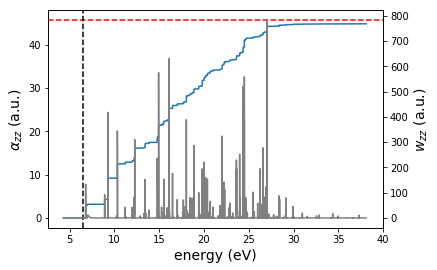

In [129]:
%matplotlib inline

fig, ax1 = plt.subplots()

ax1.set_xlabel('energy (eV)',size = 14)
plt.ylabel(r'$\alpha_{zz}$ (a.u.)',size = 14)
plt.axhline(y=C6H6_alpha_ref['alphaZ'], color='r', linestyle='--')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[rVal]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
ax1.plot(e,np.array(alpha_zz))

ax2 = ax1.twinx()
ax2.plot(e,w_zz,color='grey',linestyle='-')
plt.xlim(xmax=40)
plt.ylabel(r'$w_{zz}$ (a.u.)',size=14)
plt.show()